<a href="https://colab.research.google.com/github/Amirhosein-javadi/Medical-Imaging/blob/main/Cancer_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
with open('/content/drive/MyDrive/MedicalImage-Team/LiTS17/Info.txt') as f:
    lines = f.readlines()

In [3]:
layer_properties = []

for i in range(2,len(lines)):
    line = lines[i]
    line_split = line.split()
    dana_num = int(line_split[0])
    first_layer = int(line_split[5][1:-1]) 
    last_later = int(line_split[-1][0:-1])
    data_dict = {"dana_num" : dana_num,
                "first_layer" : first_layer,
                "last_layer" : last_later
                }
    layer_properties.append(data_dict)

layer_properties;

## Args

In [4]:
class Args():
    def __init__(self):
        
        self.lr = 0.001
        self.epochs = 50
        self.batch_size = 16
        
        self.alpha = 0.5 #BCE coeff
        self.beta = 0.5 #Dice coeff
        
        self.smooth_weight = 0.01 
        self.seg_weight = 0.5 
        self.loss = 'mse' 
        self.load_model = None
        self.initial_epoch = 0 
        self.int_steps = 7 
        self.int_downsize = 2 
        self.model_dir = './trained-models/torch/1/'

args = Args()

# Import

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as f

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Model

In [7]:
class Model(nn.Module):
  def __init__(self):
        super().__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 10, kernel_size=(2,2,2), padding=(1,1,1)),
            nn.BatchNorm3d(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2))
            )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(10, 40, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(40),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.group3 = nn.Sequential(
            nn.Conv3d(40, 20, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(20),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.group4 = nn.Sequential(
            nn.Conv3d(20, 10, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.linear1 = nn.Linear(in_features=1200,out_features=30,bias=False)

  def forward(self, x):
        x = self.group1(x)  # (k,512,512) -> (k,256,256)
        x = self.group2(x)  # (k,256,256) -> (k,64,64)
        x = self.group3(x)  # (k,64,64)   -> (k,16,16)
        x = self.group4(x)  # (k,16,16)   -> (k,4,4)
        x = torch.flatten(x)
        x = self.linear1(x)
        x = torch.sigmoid(x)
        return x

In [8]:
class Model_NoSigmoid(nn.Module):
  def __init__(self):
        super().__init__()

        self.group1 = nn.Sequential(
            nn.Conv3d(1, 10, kernel_size=(2,2,2), padding=(1,1,1)),
            nn.BatchNorm3d(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2))
            )
        
        self.group2 = nn.Sequential(
            nn.Conv3d(10, 40, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(40),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.group3 = nn.Sequential(
            nn.Conv3d(40, 20, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(20),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.group4 = nn.Sequential(
            nn.Conv3d(20, 10, kernel_size=(2,4,4), padding=(1,2,2), stride=(1, 2, 2)),
            nn.BatchNorm3d(10),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)))
        
        self.linear1 = nn.Linear(in_features=1200,out_features=30,bias=False)

  def forward(self, x):
        x = self.group1(x)  # (k,512,512) -> (k,256,256)
        x = self.group2(x)  # (k,256,256) -> (k,64,64)
        x = self.group3(x)  # (k,64,64)   -> (k,16,16)
        x = self.group4(x)  # (k,16,16)   -> (k,4,4)
        x = torch.flatten(x)
        x = self.linear1(x)
        #x = torch.sigmoid(x)
        return x

In [9]:
model = Model()
x = torch.rand(1,1,30,256,256)
y = model(x)
y.shape

torch.Size([30])

In [10]:
y

tensor([0.3932, 0.4514, 0.6202, 0.6581, 0.3647, 0.0821, 0.7254, 0.5164, 0.6646,
        0.7753, 0.4764, 0.6011, 0.6818, 0.4423, 0.4273, 0.3301, 0.3760, 0.3943,
        0.5310, 0.3987, 0.6106, 0.4772, 0.1452, 0.4947, 0.6485, 0.3440, 0.4402,
        0.4317, 0.7501, 0.3736], grad_fn=<SigmoidBackward0>)

# Dataloader

In [11]:
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import nibabel as nib
import glob
import cv2

class MyCustomDataset(Dataset):
    def __init__(self, I_path,k):
        self.image_path = I_path
        self.width = 256
        self.height = 256
        #self.label_path = L_path
        self.k = k

    def __len__(self):
        return len(self.image_path) # Return the size of dataset

    def __getitem__(self, idx): # Get an index

        k = self.k #30
        image_list = []
        label_list = []

        data_number = int(self.image_path[idx][62:-4])
        data_char = layer_properties[data_number]
        first_layer = data_char["first_layer"]
        last_layer = data_char["last_layer"]

        image_data = np.asarray(nib.load(self.image_path[idx]).dataobj) # Convert the .nii object to array
        label_data = np.zeros((image_data.shape[2]))
        label_data[first_layer:last_layer+1] = 1

        for j in range(0,image_data.shape[2]-k,k): # image_data.shape[2]-1 to stop creating data with hight == 1
            image = image_data[:,:,j:j+k].astype('float32')  # Slice  the image
            image[image < -200] = -200
            image[image > 250] = 250
            image = cv2.resize(image, (self.width, self.height))
            image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
            image = torch.from_numpy(image)
            image = torch.unsqueeze(image,0)
            image = torch.permute(image, (0, 3, 1, 2))  # (1,512,512,k) --> (1,k,512,512)

            label = label_data[j:j+k].astype('float32') # Slice  the label
            label = torch.from_numpy(label)


            image_list.append(image) # Add to the list(Dataset) 
            label_list.append(label) # Add to the list(Dataset)
      
        return image_list,label_list

In [12]:
Train_size = 100
Validation_size = 30

In [13]:
I_path_1 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 1/volume-'+ str(i)+'.nii' for i in range(28)]
I_path_2 = ['/content/drive/MyDrive/LITS Challenge/Training Batch 2/volume-'+ str(i)+'.nii' for i in range(28,131)]
I_path = I_path_1 + I_path_2

I_path_Train = I_path[:Train_size]
I_path_Val = I_path[Train_size:Train_size+Validation_size]

print(len(I_path_Train), len(I_path_Val))

100 30


In [14]:
k = 30

MyDataset_Train = MyCustomDataset(I_path_Train,k)
My_Dataloader_Train = DataLoader(MyDataset_Train, batch_size=1, shuffle=True, num_workers=0)

MyDataset_Val = MyCustomDataset(I_path_Val,k)
My_Dataloader_Val = DataLoader(MyDataset_Val, batch_size=1, shuffle=True, num_workers=0)

My_Dataloader = {
    'train' : My_Dataloader_Train,
    'val'   : My_Dataloader_Val
}

In [15]:
model = Model_NoSigmoid().to(device)

In [16]:
PATH = "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best_Detector.pth"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
## Resnet3d is also a good Net
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, threshold=1e-8, verbose=True)
#loss_func = nn.MSELoss()
# BCE
# BCELosswithlogit
loss_func = nn.BCEWithLogitsLoss()

In [20]:
num_epochs = 10
best_loss = 0.3404
best_epoch = 0
train_result = []
val_result = []

Thrshold =  0 # Sigmoid --> 0.5

In [21]:
def update_confusion_matrix(confusion_matrix, y_pred, y, Thrshold):
    y_pred= y_pred.cpu().detach().numpy()
    y_pred = np.int32((y_pred>Thrshold)*1)
    y = np.int32(y.cpu().detach().numpy()[0])
    n = len(y)
    for i in range(n):
        confusion_matrix[y,y_pred] += 1
    return confusion_matrix

def Performance_Estimator(confusion_matrix):
    NumberofData = np.sum(confusion_matrix)          
    accuracy = (confusion_matrix[0,0] + confusion_matrix[1,1]) / NumberofData
    precision = confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[0,1])
    recall = confusion_matrix[1,1] / (confusion_matrix[1,1] + confusion_matrix[1,0])
    f1 = 2 * precision * recall / (precision + recall)

    return accuracy, precision, recall, f1

##### No gradient accumulation

In [ ]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10) 
    confusion_matrix_train = np.zeros((2,2))
    confusion_matrix_val = np.zeros((2,2))
    for phase in ['train','val']:
        if phase == "train":
            model.train() # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        slice_num = 0
        # Iterate over data
                
        for batch in My_Dataloader[phase]:
            image_list, label_list = batch
            for counter in range(len(image_list)):
                image = image_list[counter]
                label = label_list[counter]
                image = image.to(device)
                label = label.to(device)
            
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(True):
                    output_model = model(image.float())
                    loss = loss_func(output_model.float() , label.float().squeeze()) 

                    # mean loss for some batch

                if phase == 'train':
                    loss.backward()
                    optimizer.step() 
                    confusion_matrix_train = update_confusion_matrix(confusion_matrix_train, output_model, label, Thrshold) 
                if phase == 'val':
                    confusion_matrix_val = update_confusion_matrix(confusion_matrix_val, output_model, label, Thrshold) 
                
                running_loss += loss.item() * image.shape[0]  # image.shape[0] = 1
                
                slice_num += 1

        if phase == "train":
            epoch_loss = running_loss / slice_num
            accuracy, precision, recall, f1 = Performance_Estimator(confusion_matrix_train)

        if phase == "val":
            epoch_loss = running_loss / slice_num
            scheduler.step(epoch_loss)
            accuracy, precision, recall, f1 = Performance_Estimator(confusion_matrix_val)
            
        if phase == "val" and (epoch_loss) < best_loss:
            best_loss = epoch_loss
            best_model = model
            best_epoch = epoch
            torch.save(best_model.state_dict(), "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best_Detector.pth")   
            print('saved')

        print('Phase: {}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, f1: {:.4f}, Loss: {:.4f}, Best Loss: {:.4f}, Best Epoch: {:.4f}'
              .format(phase, accuracy, precision, recall, f1, epoch_loss, best_loss , best_epoch))


##### gradient accumulation

In [ ]:
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10) 
    confusion_matrix_train = np.zeros((2,2))
    confusion_matrix_val = np.zeros((2,2))
    for phase in ['train','val']:
        if phase == "train":
            model.train() # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        slice_num = 0
        # Iterate over data
                
        for batch in My_Dataloader[phase]:
            image_list, label_list = batch
            for counter in range(len(image_list)):
                image = image_list[counter]
                label = label_list[counter]
                image = image.to(device)
                label = label.to(device)

                # forward
                with torch.set_grad_enabled(True):
                    output_model = model(image.float())
                    loss = loss_func(output_model.float() , label.float().squeeze())
                    # mean loss for some batch

                if phase == 'train':
                    loss /= len(image_list)
                    loss.backward()
                    confusion_matrix_train = update_confusion_matrix(confusion_matrix_train, output_model, label, Thrshold) 
                if phase == 'val':
                    confusion_matrix_val = update_confusion_matrix(confusion_matrix_val, output_model, label, Thrshold) 
                
                running_loss += loss.item() * image.shape[0]  # image.shape[0] = 1
                
                slice_num += 1

            optimizer.step() 
            optimizer.zero_grad()

        if phase == "train":
            epoch_loss = running_loss / slice_num
            accuracy, precision, recall, f1 = Performance_Estimator(confusion_matrix_train)

        if phase == "val":
            epoch_loss = running_loss / slice_num
            scheduler.step(epoch_loss)
            accuracy, precision, recall, f1 = Performance_Estimator(confusion_matrix_val)
            
        if phase == "val" and (epoch_loss) < best_loss:
            best_loss = epoch_loss
            best_model = model
            best_epoch = epoch
            torch.save(best_model.state_dict(), "/content/drive/MyDrive/MedicalImage-Team/LiTS17/best_Detector.pth")   
            print('saved')

        print('Phase: {}, accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, f1: {:.4f}, Loss: {:.4f}, Best Loss: {:.4f}, Best Epoch: {:.4f}'
              .format(phase, accuracy, precision, recall, f1, epoch_loss, best_loss , best_epoch))


Epoch 0/9
----------
Phase: train, accuracy: 0.8055, precision: 0.7414, recall: 0.7438, f1: 0.7426, Loss: 0.0163, Best Loss: 0.3404, Best Epoch: 0.0000
Phase: val, accuracy: 0.6556, precision: 0.4455, recall: 0.8755, f1: 0.5906, Loss: 0.6452, Best Loss: 0.3404, Best Epoch: 0.0000
Epoch 1/9
----------
Phase: train, accuracy: 0.8213, precision: 0.7765, recall: 0.7512, f1: 0.7636, Loss: 0.0138, Best Loss: 0.3404, Best Epoch: 0.0000
saved
Phase: val, accuracy: 0.7740, precision: 0.7460, recall: 0.5873, f1: 0.6572, Loss: 0.2879, Best Loss: 0.2879, Best Epoch: 1.0000
Epoch 2/9
----------
Phase: train, accuracy: 0.8282, precision: 0.7750, recall: 0.7659, f1: 0.7704, Loss: 0.0122, Best Loss: 0.2879, Best Epoch: 1.0000
Phase: val, accuracy: 0.5752, precision: 0.3460, recall: 0.9190, f1: 0.5028, Loss: 0.9165, Best Loss: 0.2879, Best Epoch: 1.0000
Epoch 3/9
----------
Phase: train, accuracy: 0.8301, precision: 0.7732, recall: 0.7770, f1: 0.7751, Loss: 0.0110, Best Loss: 0.2879, Best Epoch: 1.0000

In [ ]:
output_model.float().shape, label.shape

(torch.Size([30]), torch.Size([1, 30]))

In [ ]:
image.shape

torch.Size([1, 1, 30, 256, 256])

In [ ]:
image.shape[0]

1

In [ ]:
output_model,label

(tensor([7.0417e-06, 2.1013e-06, 1.8134e-06, 9.7120e-07, 3.5216e-07, 5.0031e-08,
         1.2758e-07, 5.6598e-09, 2.5006e-09, 2.8088e-10, 1.2989e-09, 1.1319e-09,
         5.2735e-10, 1.3549e-09, 1.8664e-10, 6.7358e-10, 2.8173e-10, 4.0469e-09,
         5.4651e-09, 7.2120e-11, 5.0766e-12, 1.3384e-11, 8.8302e-12, 8.4846e-13,
         2.0914e-11, 9.5695e-12, 5.7002e-11, 3.5340e-10, 2.4921e-10, 5.6907e-10],
        device='cuda:0', grad_fn=<SigmoidBackward0>),
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]], device='cuda:0'))

## Test

In [ ]:
batch = next(iter(My_Dataloader_Val))
image_list, label_list = batch

In [ ]:
for counter in range(len(image_list)):
    image = image_list[counter]
    label = label_list[counter]
    image = image.to(device)
    label = label.to(device)
    output_model = model(image.float())
    print(output_model) 
    print(label) 
    print('-' * 10) 


tensor([-6.1041, -6.6259, -6.6980, -6.5294, -7.3888, -7.1989, -7.0845, -6.9538,
        -7.8963, -7.7780, -7.8727, -7.9195, -7.5012, -7.8508, -7.7819, -8.1136,
        -8.1386, -8.2196, -7.9393, -7.5630, -7.9065, -7.6223, -7.1433, -7.2938,
        -7.0257, -5.9183, -5.9990, -6.0047, -5.9306, -5.3194], device='cuda:0',
       grad_fn=<SqueezeBackward3>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]], device='cuda:0')
----------
tensor([-4.5878, -4.9318, -4.9537, -5.1097, -5.7834, -5.5699, -5.2615, -5.5446,
        -6.1856, -6.1462, -5.5344, -6.2756, -5.8245, -6.2592, -5.9901, -6.2435,
        -6.4502, -6.3363, -6.0096, -5.5280, -5.5226, -5.5426, -4.9361, -5.1678,
        -4.6858, -3.9350, -4.1021, -4.2774, -4.1872, -3.7078], device='cuda:0',
       grad_fn=<SqueezeBackward3>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 

In [ ]:
batch = next(iter(My_Dataloader_Train))
image_list, label_list = batch

In [ ]:
for counter in range(len(image_list)):
    image = image_list[counter]
    label = label_list[counter]
    image = image.to(device)
    label = label.to(device)
    output_model = model(image.float())
    print(output_model) 
    print(label) 
    print('-' * 10) 

tensor([-7.0676, -6.9159, -7.0214, -7.3953, -7.6123, -7.7372, -7.1430, -7.4089,
        -8.0728, -7.6097, -7.0896, -7.0992, -7.0361, -7.2979, -6.3645, -6.8053,
        -6.7272, -6.5897, -7.0264, -5.8617, -5.6859, -5.6786, -5.5473, -5.8920,
        -5.8649, -3.6005, -2.9389, -3.3024, -1.9005, -1.9478], device='cuda:0',
       grad_fn=<SqueezeBackward3>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]], device='cuda:0')
----------
tensor([-7.1233, -6.7311, -7.0100, -7.4414, -7.7579, -8.2631, -7.5404, -8.4887,
        -8.9249, -8.4200, -8.0154, -8.2221, -8.1836, -8.6935, -8.6444, -8.8666,
        -8.3381, -8.2702, -9.0869, -7.8987, -7.9513, -8.0632, -7.9188, -7.9375,
        -7.8333, -5.5209, -5.4161, -5.9098, -4.0503, -4.1930], device='cuda:0',
       grad_fn=<SqueezeBackward3>)
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 

In [ ]:
len(image_list)

7

In [ ]:
import matplotlib.pyplot as plt
idx = 5
image_data = np.asarray(nib.load(I_path_Train[idx]).dataobj)
image_data_2 = image_data
image_data_2[image_data_2 < -200] = -200
image_data_2[image_data_2 > 250] = 250

In [ ]:
image_data.shape[2]

537

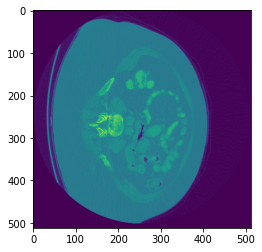

In [ ]:
plt.imshow(image_data[:,:,image_data.shape[2]//2])

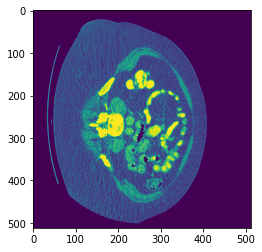

In [ ]:
plt.imshow(image_data_2[:,:,image_data.shape[2]//2])

(array([[512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-1024. ,  -800.5,  -577. ,  -353.5,  -130. ,    93.5,   317. ,
          540.5,   764. ,   987.5,  1211. ]),
 <a list of 512 Lists of Patches objects>)

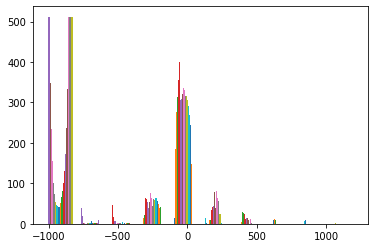

In [ ]:
plt.hist(image_data[:,:,image_data.shape[2]//2])

(array([[512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-200., -155., -110.,  -65.,  -20.,   25.,   70.,  115.,  160.,
         205.,  250.]),
 <a list of 512 Lists of Patches objects>)

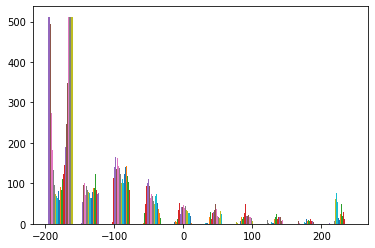

In [ ]:
plt.hist(image_data_2[:,:,image_data.shape[2]//2])

In [ ]:
loss = nn.BCEWithLogitsLoss()
input = torch.randn(3, requires_grad=True)
target = torch.empty(3).random_(2)
input,target,loss(input, target),loss(target,input)

(tensor([-0.3712, -1.4745, -0.0658], requires_grad=True),
 tensor([0., 1., 1.]),
 tensor(0.9773, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 tensor(1.6200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>))